## Imports

In [1]:
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LeakyReLU
from keras.utils.vis_utils import plot_model
from keras.layers import Reshape
from keras.layers import Conv2DTranspose

import numpy as np
import matplotlib.pyplot as plt
import time
import os
import cv2

Using TensorFlow backend.


## Load data

In [2]:
def load_data():
    return np.array([cv2.imread('32x32/' + f) for f in os.listdir('32x32/')])

In [3]:
trainX = load_data()
print('Train', trainX.shape)

Train (63569, 32, 32, 3)


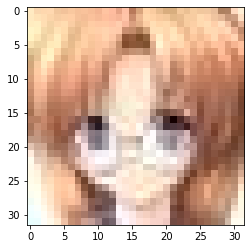

In [4]:
plt.imshow(cv2.cvtColor(trainX[0], cv2.COLOR_BGR2RGB))
plt.show()

## Preview digits

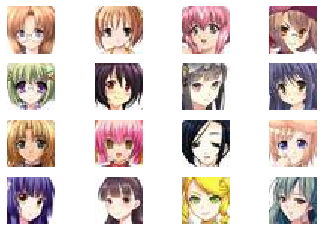

In [5]:
# plot images from the training dataset
for i in range(16):
    # define subplot
    plt.subplot(4, 4, 1 + i)
    # turn off axis
    plt.axis('off')
    # plot raw pixel data
    plt.imshow(cv2.cvtColor(trainX[i], cv2.COLOR_BGR2RGB))
    
plt.show()

## Define the Discriminator

In [6]:
# define the standalone discriminator model
def define_discriminator(in_shape=(32,32,3)):
    model = Sequential()
    model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same', input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

# define model
model = define_discriminator()
# summarize the model
model.summary()

W1213 13:32:38.158382 139946357249856 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/dist-packages/keras/backend/tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1213 13:32:38.176029 139946357249856 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/dist-packages/keras/backend/tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1213 13:32:38.180371 139946357249856 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/dist-packages/keras/backend/tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1213 13:32:38.203487 139946357249856 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/dist-packages/keras/backend/tensorflow_backend.py:148: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W1213 13:32:38.211614 

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 16, 16, 64)        1792      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 64)          36928     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 8, 8, 64)          0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 8, 8, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4096)             

### Prepare data for training

In [7]:
def convert_trainX(trainX):
    X = trainX.astype('float32')
    X = X / 255.0
    return X

dataset = convert_trainX(trainX)
dataset.shape

(63569, 32, 32, 3)

### Define methods for generating:
- real samples (just sample from the dataset)
- random fake samples - all the values are random and they represent noise

In [8]:
# select real samples + their labels: 1 for REAL as 0 represents FAKE
def generate_real_samples(dataset, n_samples):
    # choose random instances
    ix = np.random.randint(0, dataset.shape[0], n_samples)
    # retrieve selected images
    X = dataset[ix]
    # generate 'real' class labels (1)
    y = np.ones((n_samples, 1))
    return X, y

# generate n fake samples with class labels
def generate_fake_samples(n_samples):
    # generate uniform random numbers in [0,1]
    X = np.random.rand(32 * 32 * 3 * n_samples)
    # reshape into a batch of grayscale images
    X = X.reshape((n_samples, 32, 32, 3))
    # generate 'fake' class labels (0)
    y = np.zeros((n_samples, 1))
    return X, y

### Train the Discriminator on real + randomly generated images

In [9]:
# train the discriminator model
def train_discriminator(model, dataset, n_iter=100, n_batch=256):
    half_batch = int(n_batch / 2)
    # manually enumerate epochs
    for i in range(n_iter):
        # get randomly selected 'real' samples
        X_real, y_real = generate_real_samples(dataset, half_batch)
        # update discriminator on real samples
        _, real_acc = model.train_on_batch(X_real, y_real)
        # generate 'fake' examples
        X_fake, y_fake = generate_fake_samples(half_batch)
        # update discriminator on fake samples
        _, fake_acc = model.train_on_batch(X_fake, y_fake)
        # summarize performance
        print('>%d real=%.0f%% fake=%.0f%%' % (i+1, real_acc*100, fake_acc*100))

# define the discriminator model
model = define_discriminator()
# fit the model
train_discriminator(model, dataset)

>1 real=78% fake=13%
>2 real=87% fake=19%
>3 real=91% fake=19%
>4 real=88% fake=20%
>5 real=90% fake=16%
>6 real=92% fake=21%
>7 real=95% fake=23%
>8 real=93% fake=21%
>9 real=94% fake=24%
>10 real=97% fake=29%
>11 real=94% fake=27%
>12 real=96% fake=33%
>13 real=94% fake=29%
>14 real=91% fake=28%
>15 real=97% fake=35%
>16 real=95% fake=41%
>17 real=95% fake=34%
>18 real=91% fake=48%
>19 real=93% fake=45%
>20 real=91% fake=44%
>21 real=98% fake=53%
>22 real=91% fake=53%
>23 real=95% fake=45%
>24 real=93% fake=55%
>25 real=96% fake=48%
>26 real=96% fake=65%
>27 real=94% fake=62%
>28 real=91% fake=66%
>29 real=94% fake=72%
>30 real=93% fake=66%
>31 real=95% fake=65%
>32 real=93% fake=70%
>33 real=95% fake=66%
>34 real=93% fake=81%
>35 real=94% fake=74%
>36 real=91% fake=85%
>37 real=94% fake=87%
>38 real=93% fake=86%
>39 real=87% fake=86%
>40 real=93% fake=80%
>41 real=91% fake=94%
>42 real=91% fake=85%
>43 real=90% fake=91%
>44 real=95% fake=88%
>45 real=92% fake=91%
>46 real=91% fake=9

### Define the Generator

In [22]:
from keras.layers import BatchNormalization, ReLU

In [27]:
# define the standalone generator model
def define_generator(latent_dim):
    model = Sequential()
    n_nodes = 256 * 8 * 8
    model.add(Dense(n_nodes, input_dim=latent_dim))
#     model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((8, 8, 256)))
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
#     model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2DTranspose(64, (4,4), strides=(2,2), padding='same'))
#     model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(3, (8,8), activation='sigmoid', padding='same'))
    return model

# define the size of the latent space
latent_dim = 100
# define the generator model
model = define_generator(latent_dim)
model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 16384)             1654784   
_________________________________________________________________
leaky_re_lu_21 (LeakyReLU)   (None, 16384)             0         
_________________________________________________________________
reshape_7 (Reshape)          (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose_13 (Conv2DT (None, 16, 16, 128)       524416    
_________________________________________________________________
leaky_re_lu_22 (LeakyReLU)   (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_transpose_14 (Conv2DT (None, 32, 32, 64)        131136    
_________________________________________________________________
leaky_re_lu_23 (LeakyReLU)   (None, 32, 32, 64)      

### Define methods for generating:
- latent points for the generator
- fake samples using the generator model

In [12]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
    # generate points in the latent space
    x_input = np.random.randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

# use the generator to generate n fake examples, with class labels
def generate_fake_samples_with_generator(g_model, latent_dim, n_samples):
    # generate points in latent space
    x_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    X = g_model.predict(x_input)
    # create 'fake' class labels (0)
    y = np.zeros((n_samples, 1))
    return X, y

### Preview what the Generator generates without training

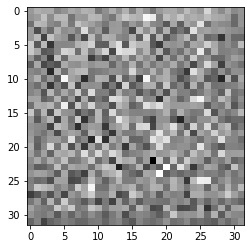

In [13]:
# size of the latent space
latent_dim = 100
# define the discriminator model
model = define_generator(latent_dim)
# generate samples
n_samples = 16
X, _ = generate_fake_samples_with_generator(model, latent_dim, n_samples)
i = 1
plt.imshow(X[i, :, :, 0], cmap='gray_r')
# show the figure
plt.show()

### Define the generator+discriminator model that will update generator's weights
- the generator's aim is to produce fake samples that look like real samples
- backpropagation will not modify discriminator's weights

In [28]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
    # make weights in the discriminator not trainable
    d_model.trainable = False
    # connect them
    model = Sequential()
    # add generator
    model.add(g_model)
    # add the discriminator
    model.add(d_model)
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)

### Define the `train` method for both generator and discriminator
1. Train discriminator on 50% real samples (from the dataset) and 50% fake samples generated by the generator
2. Train generator as follows:
  - feed latent points into the generator
  - take generator's output and input to the discriminator
  - compute discriminator's loss when all generated samples' labels were '1' ("REAL")
  - update generator's weights accordingly
    - discriminator outputs 0.25: bigger penalty (poor 'fake' sample)
    - discriminator outputs 0.9: smaller penalty (good 'fake' sample)

In [16]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=256, save_every=10):
    bat_per_epo = int(dataset.shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    acc_real_list, acc_fake_list = [], []
    loss_real_list, loss_fake_list = [], []

    timestamp = time.strftime("%Y-%m-%d_%H:%M:%S")
    if not os.path.isdir(timestamp):
        os.mkdir(timestamp)
    print(f">>> MODEL AND ITS EVALUATION CAN BE FOUND IN {timestamp} DIRECTORY :)")

    # manually enumerate epochs
    for i in range(n_epochs):
        # enumerate batches over the training set
        for j in range(bat_per_epo):
            # get randomly selected 'real' samples
            X_real, y_real = generate_real_samples(dataset, half_batch)
            # generate 'fake' examples
            X_fake, y_fake = generate_fake_samples_with_generator(g_model, latent_dim, half_batch)
            # create training set for the discriminator
            X, y = np.vstack((X_real, X_fake)), np.vstack((y_real, y_fake))
            # train distriminator with 50% fake examples and 50% real examples
            d_loss, _ = d_model.train_on_batch(X, y)
            # prepare points in latent space as input for the generator
            X_gan = generate_latent_points(latent_dim, n_batch)
            # create inverted labels for the fake samples
            y_gan = np.ones((n_batch, 1))
            # update the generator via the discriminator's error
            g_loss = gan_model.train_on_batch(X_gan, y_gan)

            # summarize loss on this batch
            # print('\t >%d, %d/%d, d=%.3f, g=%.3f' % (i+1, j+1, bat_per_epo, d_loss, g_loss))

        # EVALUATION
        n_samples = 64
        # prepare real samples
        X_real, y_real = generate_real_samples(dataset, n_samples)
        # evaluate discriminator on real examples
        loss_real, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
        acc_real_list.append(acc_real); loss_real_list.append(loss_real)

        # prepare fake examples
        x_fake, y_fake = generate_fake_samples_with_generator(g_model, latent_dim, n_samples)
        # evaluate discriminator on fake examples
        loss_fake, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
        acc_fake_list.append(acc_fake); loss_fake_list.append(loss_fake)

        print('\n> %d, real_acc=%.3f, fake_acc=%.3f' % (i+1, acc_real, acc_fake))
        print('> %d, real_loss=%.3f, fake_loss=%.3f\n' % (i+1, loss_real, loss_fake))

        if (i+1) % save_every == 0:
            print()
            # save generating images result
            save_images_plot(x_fake, i, timestamp=timestamp, n=8)

            # save plot with accuracy
            save_measure_plot(acc_real_list, acc_fake_list, i, label='accuracy', timestamp=timestamp)

            # save plot with loss
            save_measure_plot(loss_real_list, loss_fake_list, i, label='loss', timestamp=timestamp)

            # save model
            save_model(g_model, i, timestamp=timestamp)

In [17]:
def save_measure_plot(real_list, fake_list, epoch, label='accuracy', timestamp=''):
    print("[ ] Creating plots for %s, epoch %d..." % (label, epoch+1))
    filename = '%s_%s_plot_e%03d.png' % (timestamp, label, epoch+1)
    plt.figure(figsize=(14, 8))

    # plt.subplot(121)
    plt.plot([i for i in range(len(real_list))], real_list, label=f"real {label}")

    # plt.subplot(122)
    plt.plot([i for i in range(len(fake_list))], fake_list, label=f"fake {label}")
    plt.title("real / fake %s" % (label))
  
    plt.legend(loc="best")
    plt.savefig(os.path.join(timestamp, filename))
    plt.close()

In [18]:
# create and save a plot of generated images (reversed grayscale)
def save_images_plot(examples, epoch, n=4, timestamp=''):
    print("[ ] Creating images preview of %d examples, epoch %d..." % (n*n, epoch+1))
    plt.figure(figsize=(15,15))
    for i in range(n * n):
        plt.subplot(n, n, 1 + i)
        plt.axis('off')
        plt.imshow(cv2.cvtColor(examples[i], cv2.COLOR_BGR2RGB))
    filename = '%s_generated_plot_e%03d.png' % (timestamp, epoch+1)
    plt.savefig(os.path.join(timestamp, filename))
    plt.close()

In [19]:
def save_model(g_model, epoch, timestamp=''):
    if not os.path.isdir(os.path.join(timestamp, 'model')):
        os.mkdir(os.path.join(timestamp, 'model'))
    filename = os.path.join(timestamp, 'model', 'generator_%03d.h5' % (epoch + 1))
    g_model.save(filename)

In [29]:
train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=80, save_every=10)

>>> MODEL AND ITS EVALUATION CAN BE FOUND IN 2019-12-13_15:49:41 DIRECTORY :)


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'



> 1, real_acc=0.688, fake_acc=0.000
> 1, real_loss=0.683, fake_loss=0.725


> 2, real_acc=0.047, fake_acc=0.766
> 2, real_loss=0.710, fake_loss=0.688


> 3, real_acc=0.078, fake_acc=0.531
> 3, real_loss=0.709, fake_loss=0.692


> 4, real_acc=0.016, fake_acc=1.000
> 4, real_loss=0.712, fake_loss=0.679


> 5, real_acc=0.062, fake_acc=1.000
> 5, real_loss=0.714, fake_loss=0.667


> 6, real_acc=0.469, fake_acc=0.609
> 6, real_loss=0.693, fake_loss=0.692


> 7, real_acc=0.531, fake_acc=0.250
> 7, real_loss=0.693, fake_loss=0.696


> 8, real_acc=0.906, fake_acc=0.266
> 8, real_loss=0.689, fake_loss=0.696


> 9, real_acc=0.000, fake_acc=1.000
> 9, real_loss=0.724, fake_loss=0.664


> 10, real_acc=0.703, fake_acc=0.281
> 10, real_loss=0.692, fake_loss=0.695


[ ] Creating images preview of 64 examples, epoch 10...
[ ] Creating plots for accuracy, epoch 10...
[ ] Creating plots for loss, epoch 10...

> 11, real_acc=1.000, fake_acc=0.016
> 11, real_loss=0.686, fake_loss=0.702


> 12, real_acc=0

In [53]:
# example of loading the generator model and generating images
from keras.models import load_model

timestamp = "2019-12-10_22:12:32"
# load model
model1 = load_model(timestamp + '/model/generator_080.h5')
# generate images
latent_points = generate_latent_points(100, 64)
# generate images
X = model1.predict(latent_points)
# plot the result
save_images_plot(X, 99, timestamp=timestamp, n=8)

/usr/local/lib/python3.7/dist-packages/keras/engine/saving.py:310: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


[ ] Creating images preview of 64 examples, epoch 100...
